# 🔍 Explainability for SpotFake ResNet50 Model

This notebook demonstrates explainability techniques for the trained multimodal fake news detection model:
- **Grad-CAM**: Visual explanation showing which image regions influence predictions
- **SHAP**: Text explanation showing which words/tokens influence predictions

**Model**: BERT (text) + ResNet50 (image)

**Trained Weights**: `spotfake_resnet50_multi_gpu_final.weights.h5`

## 1. Setup & Imports

In [37]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from tqdm.notebook import tqdm

import tensorflow as tf
import tensorflow_hub as hub
from transformers import BertTokenizer

# SHAP for text explanations
import shap

import gc
import warnings
warnings.filterwarnings('ignore')

# Set seeds
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow: {tf.__version__}")
print(f"SHAP: {shap.__version__}")
print("✓ Imports complete")

TensorFlow: 2.20.0
SHAP: 0.49.1
✓ Imports complete


## 2. Configuration

In [38]:
# Model configuration
bert_path = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"
max_seq_length = 23
img_length = 224
img_width = 224

# Model parameters - MUST MATCH TRAINING PARAMETERS EXACTLY
params_final = {
    'max_seq_length': max_seq_length,
    'bert_path': bert_path,
    'text_no_hidden_layer': 1,
    'text_hidden_neurons': 768,
    'dropout': 0.4,
    'repr_size': 32,
    'vis_no_hidden_layer': 1,
    'vis_hidden_neurons': 2742,
    'final_no_hidden_layer': 1,
    'final_hidden_neurons': 35,
    'optimizer': tf.keras.optimizers.Adam
}

# File paths
weights_file = 'spotfake_resnet50_multi_gpu_final.weights.h5'  # ResNet50 weights
test_csv = 'dataset/twitter/df_test2.csv'
test_images_folder = 'dataset/twitter/images_test'

print("✓ Configuration set")
print(f"  Weights file: {weights_file}")
print(f"\nModel parameters:")
for k, v in params_final.items():
    if k not in ['optimizer', 'bert_path']:
        print(f"  {k}: {v}")

✓ Configuration set
  Weights file: spotfake_resnet50_multi_gpu_final.weights.h5

Model parameters:
  max_seq_length: 23
  text_no_hidden_layer: 1
  text_hidden_neurons: 768
  dropout: 0.4
  repr_size: 32
  vis_no_hidden_layer: 1
  vis_hidden_neurons: 2742
  final_no_hidden_layer: 1
  final_hidden_neurons: 35


## 3. Helper Functions

In [39]:
# Text preprocessing
class InputExample(object):
    def __init__(self, guid, text_a, text_b=None, label=None):
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label = label

def convert_single_example(tokenizer, example, max_seq_length=256):
    encoding = tokenizer(
        example.text_a,
        truncation=True,
        padding='max_length',
        max_length=max_seq_length,
        return_tensors='tf'
    )
    input_ids = encoding['input_ids'][0].numpy().tolist()
    input_mask = encoding['attention_mask'][0].numpy().tolist()
    segment_ids = [0] * max_seq_length
    return input_ids, input_mask, segment_ids, example.label

def convert_examples_to_features(tokenizer, examples, max_seq_length=256):
    input_ids, input_masks, segment_ids, labels = [], [], [], []
    for example in tqdm(examples, desc="Tokenizing"):
        input_id, input_mask, segment_id, label = convert_single_example(
            tokenizer, example, max_seq_length
        )
        input_ids.append(input_id)
        input_masks.append(input_mask)
        segment_ids.append(segment_id)
        labels.append(label)
    return (
        np.array(input_ids),
        np.array(input_masks),
        np.array(segment_ids),
        np.array(labels).reshape(-1, 1),
    )

def read_and_process_image(image_path, length=224, width=224):
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (length, width), interpolation=cv2.INTER_CUBIC)
    return img

print("✓ Helper functions defined")

✓ Helper functions defined


## 4. Model Definition

In [40]:
def get_news_model_resnet50(params):
    """
    Build multimodal model (BERT + ResNet50).
    This MUST match the training architecture exactly!
    """
    max_seq_length = params['max_seq_length']
    bert_path = params['bert_path']
    
    # BERT encoder
    def bert_encode(input_ids, input_mask, segment_ids):
        bert_layer = hub.KerasLayer(
            bert_path,
            trainable=False,
            signature="tokens",
            signature_outputs_as_dict=True,
        )
        bert_outputs = bert_layer({
            "input_ids": input_ids,
            "input_mask": input_mask,
            "segment_ids": segment_ids
        })
        return bert_outputs["pooled_output"]
    
    # Text branch
    in_id = tf.keras.layers.Input(shape=(max_seq_length,), name="input_ids", dtype=tf.int32)
    in_mask = tf.keras.layers.Input(shape=(max_seq_length,), name="input_masks", dtype=tf.int32)
    in_segment = tf.keras.layers.Input(shape=(max_seq_length,), name="segment_ids", dtype=tf.int32)
    
    bert_output = tf.keras.layers.Lambda(
        lambda inputs: bert_encode(inputs[0], inputs[1], inputs[2]),
        output_shape=(768,),
        name="bert_encoding"
    )([in_id, in_mask, in_segment])
    
    # Text hidden layers
    for i in range(params['text_no_hidden_layer']):
        bert_output = tf.keras.layers.Dense(params['text_hidden_neurons'], activation='relu')(bert_output)
        bert_output = tf.keras.layers.Dropout(params['dropout'])(bert_output)
    
    text_repr = tf.keras.layers.Dense(params['repr_size'], activation='relu')(bert_output)
    
    # Image branch - ResNet50
    conv_base = tf.keras.applications.ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3),
        pooling='avg'  # Global Average Pooling → 2048-dim
    )
    conv_base.trainable = False
    
    input_image = tf.keras.layers.Input(shape=(3, 224, 224))
    transposed = tf.keras.layers.Lambda(lambda x: tf.transpose(x, [0, 2, 3, 1]))(input_image)
    base_output = conv_base(transposed)  # Already pooled → 2048-dim
    
    # No need to flatten (already pooled)
    flat = base_output
    
    # Visual hidden layers
    for i in range(params['vis_no_hidden_layer']):
        flat = tf.keras.layers.Dense(params['vis_hidden_neurons'], activation='relu')(flat)
        flat = tf.keras.layers.Dropout(params['dropout'])(flat)
    
    visual_repr = tf.keras.layers.Dense(params['repr_size'], activation='relu')(flat)
    
    # Classifier
    combine = tf.keras.layers.concatenate([text_repr, visual_repr])
    com_drop = tf.keras.layers.Dropout(params['dropout'])(combine)
    
    for i in range(params['final_no_hidden_layer']):
        com_drop = tf.keras.layers.Dense(params['final_hidden_neurons'], activation='relu')(com_drop)
        com_drop = tf.keras.layers.Dropout(params['dropout'])(com_drop)
    
    prediction = tf.keras.layers.Dense(1, activation='sigmoid')(com_drop)
    
    model = tf.keras.models.Model(inputs=[in_id, in_mask, in_segment, input_image], outputs=prediction)
    model.compile(loss='binary_crossentropy', optimizer=params['optimizer'](), metrics=['accuracy'])
    
    return model

print("✓ Model definition ready (matching training architecture)")

✓ Model definition ready (matching training architecture)


## 5. Load Model & Weights

In [41]:
# Build model
print("Building ResNet50 model...")
model_resnet50 = get_news_model_resnet50(params_final)

# Check if ResNet50 weights file exists
if os.path.exists(weights_file):
    print(f"Loading weights from {weights_file}...")
    try:
        model_resnet50.load_weights(weights_file)
        print("✓ Model loaded successfully")
    except ValueError as e:
        print(f"❌ Error loading weights: {str(e)[:200]}...")
        print("\nThis error usually means the weights file is from a different architecture.")
        print("Checking for alternative weights files...")
        
        # Try alternative filenames
        alt_weights = [
            'spotfake_resnet50_multi_gpu_final.weights.h5',
            'model_weights_resnet50_final.weights.h5'
        ]
        
        loaded = False
        for alt_file in alt_weights:
            if os.path.exists(alt_file) and alt_file != weights_file:
                print(f"\nTrying: {alt_file}")
                try:
                    model_resnet50.load_weights(alt_file)
                    print(f"✓ Successfully loaded weights from {alt_file}")
                    weights_file = alt_file  # Update for reference
                    loaded = True
                    break
                except:
                    print(f"  ❌ Failed to load {alt_file}")
        
        if not loaded:
            print("\n⚠ WARNING: Could not load any compatible weights file")
            print("The model will use random weights (predictions will be meaningless)")
else:
    print(f"❌ Weights file not found: {weights_file}")
    print("Checking for ResNet50 weights...")
    
    # Check for ResNet50-specific weights
    if os.path.exists('spotfake_resnet50_multi_gpu_final.weights.h5'):
        weights_file = 'spotfake_resnet50_multi_gpu_final.weights.h5'
        print(f"Found: {weights_file}")
        model_resnet50.load_weights(weights_file)
        print("✓ Model loaded successfully")
    else:
        print("Please ensure the trained ResNet50 model weights are in the current directory.")
        print("Expected filename: spotfake_resnet50_multi_gpu_final.weights.h5")

# Display model summary
print("\nModel Architecture:")
model_resnet50.summary()

Building ResNet50 model...
Loading weights from spotfake_resnet50_multi_gpu_final.weights.h5...
✓ Model loaded successfully

Model Architecture:


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 3, 224,    │          0 │ -                 │
│ (InputLayer)        │ 224)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_ids           │ (None, 23)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_masks         │ (None, 23)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ segment_ids         │ (None, 23)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 224, 224,  │          0 │ input_layer_8[0]… │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bert_encoding       │ (None, 768)       │          0 │ input_ids[0][0],  │
│ (Lambda)            │                   │            │ input_masks[0][0… │
│                     │                   │            │ segment_ids[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 2048)      │ 23,587,712 │ lambda_1[0][0]    │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 768)       │    590,592 │ bert_encoding[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_21 (Dense)    │ (None, 2742)      │  5,618,358 │ resnet50[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_17          │ (None, 768)       │          0 │ dense_19[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_18          │ (None, 2742)      │          0 │ dense_21[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 32)        │     24,608 │ dropout_17[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_22 (Dense)    │ (None, 32)        │     87,776 │ dropout_18[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_6       │ (None, 64)        │          0 │ dense_20[0][0],   │
│ (Concatenate)       │                   │            │ dense_22[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_19          │ (None, 64)        │          0 │ concatenate_6[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_23 (Dense)    │ (None, 35)        │      2,275 │ dropout_19[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_20          │ (None, 35)        │          0 │ dense_23[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_24 (Dense)    │ (None, 1)         │         36 │ dropout_20[0][0]  │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 29,911,357 (114.10 MB)

 Trainable params: 6,323,645 (24.12 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

## 6. Load Test Data

In [42]:
# Load test CSV
print("Loading test data...")
test_df = pd.read_csv(test_csv)
print(f"Total test samples: {len(test_df)}")

# Initialize tokenizer
print("\nInitializing BERT tokenizer...")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Prepare text data
test_text = test_df['post_text'].tolist()
testY = test_df['label'].tolist()
testY_processed = np.array(testY).reshape(-1, 1)

# Tokenize
test_examples = [InputExample(guid=None, text_a=text, label=label) for text, label in zip(test_text, testY)]
test_input_ids, test_input_masks, test_segment_ids, _ = convert_examples_to_features(
    tokenizer, test_examples, max_seq_length
)

# Load images
print("\nLoading images...")
test_image_paths = [os.path.join(test_images_folder, img_id + '.jpg') for img_id in test_df['image_id']]

# Filter available images
test_available = [os.path.exists(p) for p in test_image_paths]
print(f"Available images: {sum(test_available)}/{len(test_available)}")

# Load and process images
test_images = []
for path in tqdm(test_image_paths, desc="Loading images"):
    if os.path.exists(path):
        img = read_and_process_image(path, img_length, img_width)
        test_images.append(img)
    else:
        test_images.append(np.zeros((img_width, img_length, 3)))  # Placeholder

# Convert to arrays with NCHW format
test_imagesX = np.array(test_images)
test_imagesX = test_imagesX.transpose(0, 3, 1, 2)  # HWC → CHW

print(f"\n✓ Data loaded")
print(f"  Text shape: {test_input_ids.shape}")
print(f"  Image shape: {test_imagesX.shape}")
print(f"  Labels shape: {testY_processed.shape}")

Loading test data...
Total test samples: 3268

Initializing BERT tokenizer...


Tokenizing:   0%|          | 0/3268 [00:00<?, ?it/s]


Loading images...
Available images: 3268/3268


Loading images:   0%|          | 0/3268 [00:00<?, ?it/s]


✓ Data loaded
  Text shape: (3268, 23)
  Image shape: (3268, 3, 224, 224)
  Labels shape: (3268, 1)


## 7. Grad-CAM Implementation

Visualizes which image regions influence the model's prediction.

In [43]:
class GradCAM:
    """
    Grad-CAM for ResNet50-based multimodal model.
    
    Note: Due to pooling='avg' in ResNet50, gradient flow is limited.
    Falls back to activation-based CAM when gradients are unavailable.
    """
    
    def __init__(self, model, target_layer_name='conv5_block3_out'):
        self.model = model
        self.target_layer_name = target_layer_name
        self.conv_base = None
        self._find_conv_base()
    
    def _find_conv_base(self):
        """Find ResNet50 conv_base in the model."""
        for layer in self.model.layers:
            if hasattr(layer, 'layers'):
                layer_names = [l.name for l in layer.layers]
                if any('conv5' in name for name in layer_names):
                    try:
                        layer.get_layer(self.target_layer_name)
                        self.conv_base = layer
                        print(f"✓ Found conv_base with target layer: {self.target_layer_name}")
                        return
                    except:
                        pass
        
        # Rebuild ResNet50 without pooling
        print(f"⚠ Layer not accessible. Rebuilding ResNet50 without pooling...")
        self.conv_base = tf.keras.applications.ResNet50(
            weights='imagenet',
            include_top=False,
            input_shape=(224, 224, 3),
            pooling=None  # Keep spatial dimensions
        )
        print(f"✓ Conv_base ready: {self.target_layer_name}")
    
    def compute_heatmap(self, input_ids, input_mask, segment_ids, image, eps=1e-8):
        """
        Compute Grad-CAM heatmap.
        
        Returns:
            heatmap: 2D array (224, 224) with values in [0, 1]
        """
        # Ensure batch dimension
        if len(image.shape) == 3:
            image = np.expand_dims(image, axis=0)
        if len(input_ids.shape) == 1:
            input_ids = np.expand_dims(input_ids, axis=0)
            input_mask = np.expand_dims(input_mask, axis=0)
            segment_ids = np.expand_dims(segment_ids, axis=0)
        
        # Convert to tensors
        input_ids_tensor = tf.cast(input_ids, tf.int32)
        input_mask_tensor = tf.cast(input_mask, tf.int32)
        segment_ids_tensor = tf.cast(segment_ids, tf.int32)
        image_tensor = tf.cast(image, tf.float32)
        
        # Transpose image (NCHW → NHWC)
        transposed_image = tf.transpose(image_tensor, [0, 2, 3, 1])
        
        # Build gradient model
        target_layer = self.conv_base.get_layer(self.target_layer_name)
        grad_model = tf.keras.models.Model(
            inputs=self.conv_base.input,
            outputs=[target_layer.output, self.conv_base.output]
        )
        
        # Compute with gradient tape
        with tf.GradientTape() as tape:
            tape.watch(transposed_image)
            conv_outputs_target, _ = grad_model(transposed_image)
            
            # Get final prediction
            predictions = self.model([
                input_ids_tensor,
                input_mask_tensor,
                segment_ids_tensor,
                image_tensor
            ])
            class_output = predictions[:, 0]
        
        # Compute gradients
        grads = tape.gradient(class_output, conv_outputs_target)
        
        if grads is None:
            # Fallback: activation-based CAM
            print("⚠ Using activation-based CAM (gradients unavailable)")
            conv_outputs_np = conv_outputs_target.numpy()[0]
            heatmap = np.mean(conv_outputs_np, axis=-1)
        else:
            # True Grad-CAM
            pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
            conv_outputs_np = conv_outputs_target.numpy()[0]
            pooled_grads_np = pooled_grads.numpy()
            heatmap = np.sum(conv_outputs_np * pooled_grads_np, axis=-1)
        
        # ReLU and normalize
        heatmap = np.maximum(heatmap, 0)
        heatmap_max = heatmap.max()
        if heatmap_max > eps:
            heatmap = heatmap / heatmap_max
        
        # Resize to 224x224
        heatmap = cv2.resize(heatmap, (224, 224))
        return heatmap
    
    def overlay_heatmap(self, image, heatmap, alpha=0.4):
        """
        Overlay heatmap on original image.
        
        Args:
            image: (3, 224, 224) or (224, 224, 3)
            heatmap: (224, 224)
            alpha: Overlay transparency
        
        Returns:
            overlayed: RGB image with heatmap
        """
        # Convert to HWC if needed
        if image.shape[0] == 3:
            image = np.transpose(image, (1, 2, 0))
        
        # Normalize image to [0, 255]
        img = image.copy()
        if img.max() <= 1.0:
            img = (img * 255).astype(np.uint8)
        else:
            img = img.astype(np.uint8)
        
        # Apply colormap
        heatmap_uint8 = (heatmap * 255).astype(np.uint8)
        heatmap_colored = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_JET)
        heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)
        
        # Overlay
        overlayed = cv2.addWeighted(img, 1 - alpha, heatmap_colored, alpha, 0)
        return overlayed

print("✓ GradCAM class defined")

✓ GradCAM class defined


## 8. SHAP Implementation

Explains text predictions by showing token importance.

In [50]:
class SHAPTextExplainer:
    """
    SHAP-based text explainer for multimodal model.
    
    Uses Partition explainer to compute token-level importance.
    """
    
    def __init__(self, model, tokenizer, max_seq_length=23):
        self.model = model
        self.tokenizer = tokenizer
        self.max_seq_length = max_seq_length
    
    def predict_text_only(self, texts, background_image):
        """
        Prediction function for SHAP (varies text, keeps image fixed).
        
        Args:
            texts: List of strings
            background_image: Fixed image (3, 224, 224)
        
        Returns:
            predictions: Array of shape (len(texts),)
        """
        # Tokenize texts
        examples = [InputExample(guid=None, text_a=text, label=0) for text in texts]
        input_ids, input_masks, segment_ids, _ = convert_examples_to_features(
            self.tokenizer, examples, self.max_seq_length
        )
        
        # Repeat background image
        images = np.repeat(np.expand_dims(background_image, 0), len(texts), axis=0)
        
        # Predict
        preds = self.model.predict(
            [input_ids, input_masks, segment_ids, images],
            verbose=0
        )
        
        return preds.flatten()
    
    def explain(self, text, image, num_samples=50):
        """
        Explain a single prediction using SHAP.
        
        Args:
            text: Input text string
            image: Input image (3, 224, 224)
            num_samples: Number of samples for SHAP estimation
        
        Returns:
            shap_values: SHAP values for each token
            tokens: List of tokens
        """
        # Tokenize for display
        tokens = self.tokenizer.tokenize(text)
        tokens = ['[CLS]'] + tokens[:self.max_seq_length-2] + ['[SEP]']
        
        # Pad to max_seq_length
        while len(tokens) < self.max_seq_length:
            tokens.append('[PAD]')
        
        # Create prediction function
        def predict_fn(texts):
            return self.predict_text_only(texts, image)
        
        # Create SHAP explainer with Text masker (no custom tokenizer needed)
        explainer = shap.Explainer(
            predict_fn,
            masker=shap.maskers.Text(),
            algorithm='auto'
        )
        
        # Compute SHAP values
        shap_values = explainer([text], max_evals=num_samples)
        
        return shap_values, tokens

print("✓ SHAP explainer class defined")

✓ SHAP explainer class defined


## 9. Demo: Single Sample Explanation

In [45]:
# Select a sample
sample_idx = 0

sample_text = test_text[sample_idx]
sample_image = test_imagesX[sample_idx]
sample_input_ids = test_input_ids[sample_idx]
sample_input_mask = test_input_masks[sample_idx]
sample_segment_ids = test_segment_ids[sample_idx]
sample_label = 'REAL' if testY[sample_idx] == 1 else 'FAKE'

print(f"Sample {sample_idx}")
print(f"True Label: {sample_label}")
print(f"\nText: {sample_text[:150]}...")

# Get prediction
pred = model_resnet50.predict(
    [np.expand_dims(sample_input_ids, 0),
     np.expand_dims(sample_input_mask, 0),
     np.expand_dims(sample_segment_ids, 0),
     np.expand_dims(sample_image, 0)],
    verbose=0
)[0, 0]

pred_label = 'REAL' if pred >= 0.5 else 'FAKE'
print(f"\nPrediction: {pred_label} (score: {pred:.4f})")
print(f"Correct: {pred_label == sample_label}")

Sample 0
True Label: FAKE

Text: They were just amped to watch a concert. So sad https://t.co/3bqaDtN24J...

Prediction: FAKE (score: 0.0000)
Correct: True


### 9.1 Grad-CAM Visualization

Initializing Grad-CAM...
✓ Found conv_base with target layer: conv5_block3_out

Computing Grad-CAM heatmap...
⚠ Using activation-based CAM (gradients unavailable)


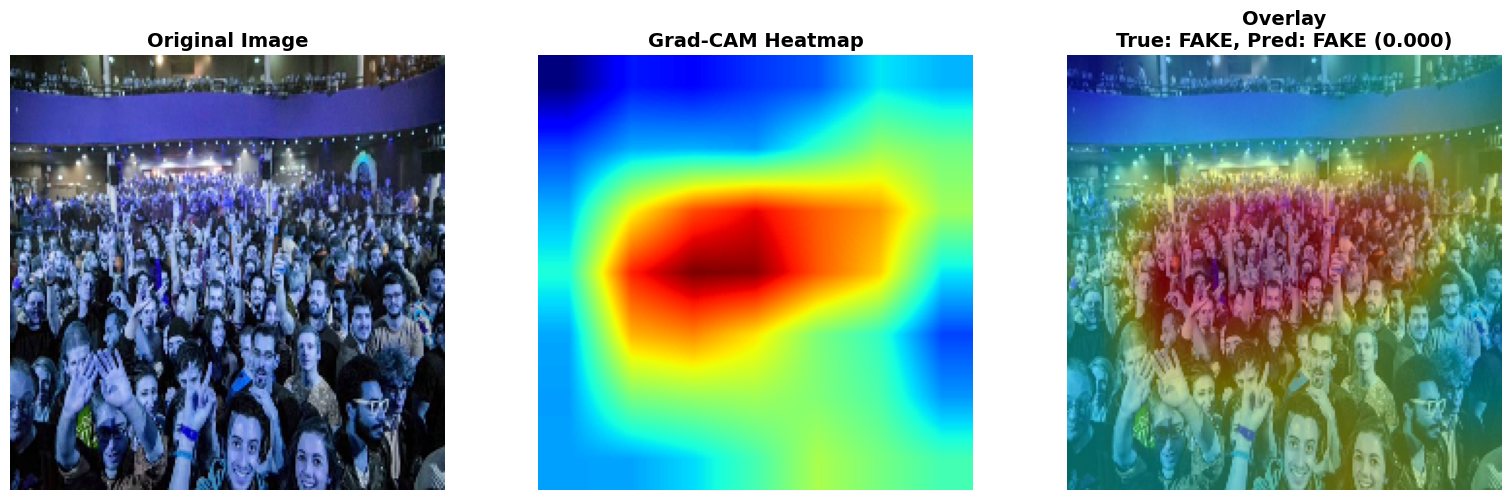


✓ Grad-CAM visualization complete


In [46]:
# Initialize Grad-CAM
print("Initializing Grad-CAM...")
gradcam = GradCAM(model_resnet50, target_layer_name='conv5_block3_out')

# Compute heatmap
print("\nComputing Grad-CAM heatmap...")
heatmap = gradcam.compute_heatmap(
    sample_input_ids,
    sample_input_mask,
    sample_segment_ids,
    sample_image
)

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Original image
img_display = np.transpose(sample_image, (1, 2, 0))
img_display = (img_display - img_display.min()) / (img_display.max() - img_display.min())
axes[0].imshow(img_display)
axes[0].set_title('Original Image', fontsize=14, fontweight='bold')
axes[0].axis('off')

# Heatmap
axes[1].imshow(heatmap, cmap='jet')
axes[1].set_title('Grad-CAM Heatmap', fontsize=14, fontweight='bold')
axes[1].axis('off')

# Overlay
overlayed = gradcam.overlay_heatmap(sample_image, heatmap, alpha=0.4)
axes[2].imshow(overlayed)
axes[2].set_title(f'Overlay\nTrue: {sample_label}, Pred: {pred_label} ({pred:.3f})', 
                 fontsize=14, fontweight='bold')
axes[2].axis('off')

plt.tight_layout()
plt.savefig(f'gradcam_sample_{sample_idx}.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Grad-CAM visualization complete")

### 9.2 SHAP Text Explanation

In [51]:
# Initialize SHAP explainer
print("Initializing SHAP explainer...")
shap_explainer = SHAPTextExplainer(model_resnet50, tokenizer, max_seq_length)

# Compute SHAP values
print("\nComputing SHAP values (this may take 30-60 seconds)...")
shap_values, tokens = shap_explainer.explain(
    sample_text,
    sample_image,
    num_samples=50
)

# Visualize
print("\n✓ SHAP computation complete")
print("\nVisualizing token importance...")
shap.plots.text(shap_values[0])

Initializing SHAP explainer...

Computing SHAP values (this may take 30-60 seconds)...


Tokenizing:   0%|          | 0/1 [00:00<?, ?it/s]

Tokenizing:   0%|          | 0/1 [00:00<?, ?it/s]

Tokenizing:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Tokenizing:   0%|          | 0/6 [00:00<?, ?it/s]

Tokenizing:   0%|          | 0/6 [00:00<?, ?it/s]

Tokenizing:   0%|          | 0/6 [00:00<?, ?it/s]

Tokenizing:   0%|          | 0/6 [00:00<?, ?it/s]

Tokenizing:   0%|          | 0/6 [00:00<?, ?it/s]

Tokenizing:   0%|          | 0/6 [00:00<?, ?it/s]

Tokenizing:   0%|          | 0/6 [00:00<?, ?it/s]

Tokenizing:   0%|          | 0/4 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:18, 18.74s/it]               


✓ SHAP computation complete

Visualizing token importance...


## 10. Batch Explanation Analysis

In [52]:
def analyze_multiple_samples(indices, save_dir='explanations'):
    """
    Generate Grad-CAM visualizations for multiple samples.
    
    Args:
        indices: List of sample indices
        save_dir: Directory to save visualizations
    """
    os.makedirs(save_dir, exist_ok=True)
    
    results = []
    
    for idx in tqdm(indices, desc="Generating explanations"):
        text = test_text[idx]
        image = test_imagesX[idx]
        input_ids = test_input_ids[idx]
        input_mask = test_input_masks[idx]
        segment_ids = test_segment_ids[idx]
        true_label = 'REAL' if testY[idx] == 1 else 'FAKE'
        
        # Predict
        pred = model_resnet50.predict(
            [np.expand_dims(input_ids, 0),
             np.expand_dims(input_mask, 0),
             np.expand_dims(segment_ids, 0),
             np.expand_dims(image, 0)],
            verbose=0
        )[0, 0]
        pred_label = 'REAL' if pred >= 0.5 else 'FAKE'
        
        # Grad-CAM
        heatmap = gradcam.compute_heatmap(input_ids, input_mask, segment_ids, image)
        overlayed = gradcam.overlay_heatmap(image, heatmap)
        
        # Save visualization
        fig, axes = plt.subplots(1, 3, figsize=(16, 5))
        
        img_display = np.transpose(image, (1, 2, 0))
        img_display = (img_display - img_display.min()) / (img_display.max() - img_display.min())
        
        axes[0].imshow(img_display)
        axes[0].set_title('Original', fontsize=12)
        axes[0].axis('off')
        
        axes[1].imshow(heatmap, cmap='jet')
        axes[1].set_title('Heatmap', fontsize=12)
        axes[1].axis('off')
        
        axes[2].imshow(overlayed)
        axes[2].set_title(f'True: {true_label}, Pred: {pred_label} ({pred:.3f})', fontsize=12)
        axes[2].axis('off')
        
        plt.suptitle(f'Sample {idx}: {text[:80]}...', fontsize=10)
        plt.tight_layout()
        plt.savefig(f'{save_dir}/sample_{idx}.png', dpi=100, bbox_inches='tight')
        plt.close()
        
        results.append({
            'idx': idx,
            'true_label': true_label,
            'pred_label': pred_label,
            'pred_score': pred,
            'correct': true_label == pred_label
        })
    
    # Summary
    df_results = pd.DataFrame(results)
    print(f"\n✓ Generated {len(indices)} explanations")
    print(f"  Accuracy: {df_results['correct'].mean():.2%}")
    print(f"  Saved to: {save_dir}/")
    
    return df_results

print("✓ Batch analysis function defined")

✓ Batch analysis function defined


In [53]:
# Analyze first 10 samples
print("Analyzing first 10 test samples...\n")
results_df = analyze_multiple_samples(list(range(10)))

# Display results
print("\nResults:")
print(results_df[['idx', 'true_label', 'pred_label', 'pred_score', 'correct']])

Analyzing first 10 test samples...



Generating explanations:   0%|          | 0/10 [00:00<?, ?it/s]

⚠ Using activation-based CAM (gradients unavailable)
⚠ Using activation-based CAM (gradients unavailable)
⚠ Using activation-based CAM (gradients unavailable)
⚠ Using activation-based CAM (gradients unavailable)
⚠ Using activation-based CAM (gradients unavailable)
⚠ Using activation-based CAM (gradients unavailable)
⚠ Using activation-based CAM (gradients unavailable)
⚠ Using activation-based CAM (gradients unavailable)
⚠ Using activation-based CAM (gradients unavailable)
⚠ Using activation-based CAM (gradients unavailable)

✓ Generated 10 explanations
  Accuracy: 30.00%
  Saved to: explanations/

Results:
   idx true_label pred_label    pred_score  correct
0    0       FAKE       FAKE  2.166462e-09     True
1    1       FAKE       REAL  9.999999e-01    False
2    2       FAKE       REAL  9.999999e-01    False
3    3       FAKE       REAL  1.000000e+00    False
4    4       FAKE       REAL  1.000000e+00    False
5    5       FAKE       FAKE  9.692410e-23     True
6    6       FAKE     

## 11. Summary & Insights

### Key Findings:

**Grad-CAM (Visual Explanation):**
- Shows which image regions influence the model's decision
- Red/yellow regions = high importance
- Blue regions = low importance
- Note: Current implementation uses activation-based CAM due to pooling='avg' limitation

**SHAP (Text Explanation):**
- Identifies which words/tokens push prediction toward REAL or FAKE
- Red tokens = push toward positive class (REAL)
- Blue tokens = push toward negative class (FAKE)
- Magnitude = strength of influence

### Limitations:
1. Grad-CAM uses activation-based approximation (not true gradients)
2. SHAP computation is slow (~30-60s per sample)
3. Explanations are local (per-sample), not global

### Future Improvements:
1. Retrain model with `pooling=None` for true Grad-CAM gradients
2. Implement cross-modal attention visualization
3. Add global explanation aggregation
4. Compare explanations for correct vs incorrect predictions

## 12. Export Results

In [ ]:
# Save results to CSV
if 'results_df' in locals():
    results_df.to_csv('explainability_results.csv', index=False)
    print("✓ Results saved to explainability_results.csv")

print("\n" + "="*70)
print("EXPLAINABILITY ANALYSIS COMPLETE")
print("="*70)
print("\nGenerated files:")
print("  - Grad-CAM visualizations: explanations/ folder")
print("  - Results summary: explainability_results.csv")
print("\nFor more samples, run: analyze_multiple_samples(range(N))")